# PRÁCTICA 1 - PROCESAMIENTO DE LENGUAJE NATURAL - MASTER EN INTELIGENCIA ARTIFICIAL APLICADA

# JOSÉ LORENTE LÓPEZ - DNI: 48842308Z

# **Text Vectorization I**

---
### Natural Language Processing
Date: Nov 11, 2022

Authors: Jerónimo Arenas-García (jarenas@ing.uc3m.es), Lorena Calvo-Bartolomé (lcalvo@pa.uc3m.es), Jesús Cid-Suero (jcid@ing.uc3m.es)

Version 1.0

---

Our goal here is to provide a basic overview of the following aspects:


*   NLP preprocessing
*   Document BoW and TF-IDF representation
*   Utilization of the latter to solve a Text Classification task




In [1]:
# Introducimos librerías necesarias para el desarrollo de la práctica

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import contractions
from nltk.tokenize import wordpunct_tokenize, sent_tokenize, word_tokenize
import colored
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from matplotlib import pyplot as plt
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
# To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

We are going to save all the files in this notebook generated into our Drive. For doing so, you must fill the variable ``path_to_folder`` with your Drive's folder in which you want to save the files. Please, note that the home path to your Drive is given by:

``
/content/drive/My Drive/
``

Hence, if you want to save this lab's results into a folder named ``NLP_IA``, then the variable ``path_to_folder`` for you should look as follows:

``
path_to_folder = '/content/drive/My Drive/NLP_IA' 
``

In [3]:
# Dirección a la que mandaremos la base de datos a utilizar

path_to_folder = 'C:/Users/José/Desktop/Master - CIII/1ºCuatrimestre/2ºSemicuatrimestre/Códigos - Python/Procesamiento del Lenguaje Natural/Lab1/data_lab1_1'  # UPDATE THIS ACCORDING TO WHERE YOU WANT TO SAVE THE FILES!!!!

## **1. Data preparation**
---


### *1.1. Data loading*

The first step to start working with text vectorization is downloading the dataset with which we will work. Here we will be using the **IMDB Dataset of 50K Movie Reviews**, which contains 50K movie reviews for natural language processing or Text analytics.


In [4]:
# Importamos (o, en caso de no tenerlo instalamos) una librería asociada a un conjunto de datasets abiertos

try:
  import opendatasets as od
except ModuleNotFoundError:
  %pip install opendatasets
  import opendatasets as od

The IMDB dataset can be downloaded from **Kaggle**. For doing so, you must create an account at [kaggle.com](https://www.kaggle.com/). 

Once you have your account, go to ``Your profile`` and select ``Edit Public Profile``. If you scroll down in this view, you will see a button named ``Create New API Token``. By clicking it will automatically download a file ``kaggle.json`` containing your **username** and **key**. You will need them for executing the next cell.

You just need to execute the following cell once, since it will store the dataset file in the drive folder you have specified above.

In [5]:
# Descargaremos este dataset que cuenta con 50k reviews de películas donde cada una va a acompañada de una etiqueta (que corresponde al sentimiento transmitido por la review; en este caso la clasificación es binaria sentimiento: positivo o negativo)

# TODO: Comment this cell after executing it the first time
od.download("https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

Skipping, found downloaded files in ".\imdb-dataset-of-50k-movie-reviews" (use force=True to force download)


Let's save the dataset as dataframe.

This dataset is oriented toward binary sentence classification, i.e., the prediction of whether each of the reviews in the dataset is positive or negative using either classification or deep learning algorithms.

Hence, we have two columns in our dataframe: the ``review`` column contains the textual information and the ``sentiment`` column contains the output labels. Here we will be working first on the ``review`` column for applying distinct types of text vectorization, and finally, we will utilize the ``sentiment`` column to carry out the sentiment analysis task.

To accelerate the process, we will be only using a third of the reviews contained in the dataset.

In [6]:
# Introducimos el dataset a un dataframe y nos quedamnos (de forma aleatoria) con un 30% de las muestras. Pasamos de 50k reviews a 15k con el fin de crear un código computacionalmente más óptimo (aunque, claro está, mejor funcionará cuantas más muestras introduzcamos)

corpus_df = pd.read_csv('imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
corpus_df = corpus_df.sample(frac=0.3, replace=True, random_state=1)
print(len(corpus_df))
corpus_df.head()

15000


,review,sentiment
33003,"Set in Paris in the year 1910, a retired old r...",positive
12172,"Basic structure of a story: Beginning, Middle,...",negative
5192,"An odd, willfully skewed biopic of Dyan Thomas...",negative
32511,"Okay, you have:<br /><br />Penelope Keith as M...",negative
43723,The larger-than-life figures of Wyatt Earp and...,positive


### *1.2. Preprocessing*

Before continuing with the vectorization task, we should structure and clean the text so that we only keep the information that allows us to capture the semantic content of the corpus. This will improve the result of our embeddings.

For this purpose, we will apply the following three steps, which are typical of any NLP processing task:

1.   Text Wrangling
2.   Tokenization
3.   Homogenization
4.   Cleaning

For the next steps, we will be using some methods available from:

*   [Natural Language Toolkit](https://www.nltk.org/)
*   [Beautiful Soup](https://pypi.org/project/beautifulsoup4/)
*   [Contractions](https://pypi.org/project/contractions/)
*   [re — Regular expression operations](https://docs.python.org/3/library/re.html)

Antes de la tearea de vectorización, es fundamental realizar una limpieza del texto con el fin de quedarnos solo con información que proporciona contenido del corpus. Esto mejorará notablemente nuestros resultados.

In [7]:
# Importamos todas las librerías asociadas al preprocesado de los datos del dataset

import re
import nltk

def check_nltk_packages():
  packages = ['punkt','stopwords','omw-1.4','wordnet']

  for package in packages:
    try:
      nltk.data.find('tokenizers/' + package)
    except LookupError:
      nltk.download(package)
check_nltk_packages()

try:
  import lxml
except ModuleNotFoundError:
  %pip install lxml

try:
  import contractions
except ModuleNotFoundError:
  %pip install contractions
  import contractions

from bs4 import BeautifulSoup
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\José\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\José\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\José\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### *1.2.1. Text Wrangling*

If we inspect the reviews, we can see that they contain many HTML tags and some URLs that we do not want to keep for our text vectorization task since they don't add much value for understanding and analyzing the text. 

Additionally, there are many English contractions ('ll, 're) that we would like to transform into their base form (will, are) to later help with the standardization process.

"Text wrangling" consistirá en eliminar tanto las etiquetas HTML, URLs y sustituir contracciones de palabras en inglés por su palabra al completo (ya que sino, para el programa, se tomarán como dos palabras diferentes)

##### **Exercise 1**

Complete the function ``wrangle_text`` that performs the text wrangling task. For doing so:

*   Make use of the library ``BeautifulSoup`` with the parser ``"lxml"`` to get rid of all HTML tags.
*   Use the function ``re.sub`` to remove all URLs in text. To this function, we need to provide a **regular expression**, i.e., a special sequence of characters that help us match or find other strings or sets of strings, using a specialized syntax held in a pattern, and a string to replace the occurrences of the regular expression found. Typically, we would use define the regular expressions as raw strings in the form r'expression'.
You can identify URLs using the pattern ``r'https://\S+|www\.\S+'``.
* Use the method ``fix`` from the ``contractions`` library to expand the contractions.

Apply the ``wrangle_text`` function into the first positive ``review`` in the corpus and save the result into a variable named ``wrangled_review``. Print the review before and after making the text wrangling.


Con wrangle_text eliminaremos las HTML tags, direcciones URL y extenderemos las contracciones de palabras para que no se tomen como palabras diferentes a las no contraidas.

In [8]:
#<SOL>
def wrangle_text(texto):
  # TODO: Implement
#</SOL>

  #<SOL>
  texto = str(texto)
  texto = BeautifulSoup(texto, "lxml").text
  texto = re.sub(r'http\S+', '', str(texto))
  texto = contractions.fix(texto)
  #</SOL>

#<SOL>
  return texto
#</SOL>

In [9]:
pp = corpus_df['review'].values

In [10]:
for i in range (15000):
    pp[i] = wrangle_text(pp[i])

d:\anaconda\envs\ids\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [11]:
corpus_df['review'] = pp

In [12]:
# Vemos en un ejemplo como ha funcionado correctamos el uso de esta función
pp[1]

'Basic structure of a story: Beginning, Middle, End.Sometimes this structure is played with, and we get Memento or Irreversible and the story plays backwards. Sometimes it is just not linear, a la Pulp Fiction. Regardless, they all have a beginning, middle and end.This is the first film I have ever seen that does not have an end.Beginning: Girl\'s best friend is expelled.Middle: Girl needs to cope without best friend.End: Non existent.Not that having an end would have saved this film, but at least it would have been complete.It is an exercise in apathy; we get a party-mix of characters, and they all turn out to be duds. Boring, vain, vapid and pallid imitations of people.And here is the action within this film: NOTHING HAPPENS. Nothing at all happens. Mischa Barton tries to talk with a plummy English accent, Dominique Swain whines a lot and Brad Renfro receives a blow job from some old guy. End of movie.By the time the credits rolled, I had a horrible feeling that many prisoners must f

#### *1.2.2. Tokenization*

Tokenization is the process of segmenting a text into words,
referred to as **tokens**. This procedure will often also break off punctuation symbols (commas, periods, etc.), phrases, and other possible meaningful elements from the text, such as separate tokens. The list of tokens resulting from tokenization becomes the input for the homogenization stage. 

The [NLTK Tokenizer Package](https://www.nltk.org/api/nltk.tokenize.html) offers several functions to perform tokenization operations on any text string. Here we will be using the ``wordpunct_tokenize`` function, which allows the separation of punctuation marks. Since sometimes we will be interested in performing the tokenization at the sentence level, we can combine ``wordpunct_tokenize`` and ``sent_tokenize``.

Cada review la separaremos en sus tokens, es decir en las palabras que la componen.

##### **Exercise 2**

* Tokenize the ``wrangled_review`` at the word level using the ``wordpunct_tokenize`` function. Save the tokenized review in a variable named ``review_tokens``.
* Tokenize the the ``wrangled_review`` at the sentence level using the combination of ``wordpunct_tokenize`` and  ``sent_tokenize`` functions. Save the tokenized review in a variable named ``review_tokens_sent``.

In [13]:
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize

def tokenize(texto):
#<SOL>
    texto = str(texto)
    review_tokens = wordpunct_tokenize(texto)
    review_tokens_sent = sent_tokenize(texto)
    return review_tokens, review_tokens_sent
#</SOL>


In [14]:
# Veamos si funciona la función haciendo la word/sentece tokenize de una review cualquiera

review_tokens = wordpunct_tokenize(pp[1])
review_tokens_sent = sent_tokenize(pp[1])

In [15]:
# Vemos como la tokenizacion por palabras funciona correctamente

review_tokens

['Basic',
 'structure',
 'of',
 'a',
 'story',
 ':',
 'Beginning',
 ',',
 'Middle',
 ',',
 'End',
 '.',
 'Sometimes',
 'this',
 'structure',
 'is',
 'played',
 'with',
 ',',
 'and',
 'we',
 'get',
 'Memento',
 'or',
 'Irreversible',
 'and',
 'the',
 'story',
 'plays',
 'backwards',
 '.',
 'Sometimes',
 'it',
 'is',
 'just',
 'not',
 'linear',
 ',',
 'a',
 'la',
 'Pulp',
 'Fiction',
 '.',
 'Regardless',
 ',',
 'they',
 'all',
 'have',
 'a',
 'beginning',
 ',',
 'middle',
 'and',
 'end',
 '.',
 'This',
 'is',
 'the',
 'first',
 'film',
 'I',
 'have',
 'ever',
 'seen',
 'that',
 'does',
 'not',
 'have',
 'an',
 'end',
 '.',
 'Beginning',
 ':',
 'Girl',
 "'",
 's',
 'best',
 'friend',
 'is',
 'expelled',
 '.',
 'Middle',
 ':',
 'Girl',
 'needs',
 'to',
 'cope',
 'without',
 'best',
 'friend',
 '.',
 'End',
 ':',
 'Non',
 'existent',
 '.',
 'Not',
 'that',
 'having',
 'an',
 'end',
 'would',
 'have',
 'saved',
 'this',
 'film',
 ',',
 'but',
 'at',
 'least',
 'it',
 'would',
 'have',
 'been

In [16]:
# Vemos como la tokenizacion por frases funciona correctamente

review_tokens_sent

['Basic structure of a story: Beginning, Middle, End.Sometimes this structure is played with, and we get Memento or Irreversible and the story plays backwards.',
 'Sometimes it is just not linear, a la Pulp Fiction.',
 "Regardless, they all have a beginning, middle and end.This is the first film I have ever seen that does not have an end.Beginning: Girl's best friend is expelled.Middle: Girl needs to cope without best friend.End: Non existent.Not that having an end would have saved this film, but at least it would have been complete.It is an exercise in apathy; we get a party-mix of characters, and they all turn out to be duds.",
 'Boring, vain, vapid and pallid imitations of people.And here is the action within this film: NOTHING HAPPENS.',
 'Nothing at all happens.',
 'Mischa Barton tries to talk with a plummy English accent, Dominique Swain whines a lot and Brad Renfro receives a blow job from some old guy.',
 'End of movie.By the time the credits rolled, I had a horrible feeling th

#### *1.2.3. Homogenization*

Homogenization is the process that aims to collapse all semantically equivalent words into a unique representative one. The homogenization process comes from multiple words sharing the same lexeme. For example, ``develop``, ``development``, ``developing``, ``developed``, ``developer``, ``developmental``, and ``developmentally``, are set of words that share the same lexeme or root and, therefore, have a certain relationship of meaning.

To homogenize the set of tokens obtained in the previous stage, the following steps need to be performed:


1.   **Lower-cased of the tokens**
2.   **Elimination of non-alphanumeric characters**, like periods, question marks, and exclamation points.
4.   **Word normalization (Stemming/Lemmatization)**, i.e., removing word terminations to preserve the root of the words and ignore grammatical information.

Let's see how to apply each of these steps to the previously selected review.

Buscamos que cada forma verbal, adverbio... todo se resuma en su forma raiz para que no signifiquen cosas diferentes (ya que aportan el mismo significado léxico a la frase). A su vez, pondremos todos los tokens en minúsculas (para que, por ejemplo Junio y junio signifiquen, como debe ser, lo mismo) y eliminaremos todos los carácteres no alfanuméricos (signos de puntuación, @, ...)

##### **Exercise 3**

Perform the following two transformations to ``review_tokens``:

1.   Convert the tokens to lowercase. Use the ``.lower()`` method.
2.   Remove non-alphanumeric tokens. You can detect them using the ``.isalnum()`` method.

Save the result in a variable named ``review_tokens_filtered``.

In [17]:
#<SOL>

# Con la siguiente función pasamos todo a minúsculas y eliminamos los caracteres no alfanuméricos

def Homogenization(texto):
    
    ayuda = []
    
    for i in range (len(texto)):
        ayuda.append(texto[i].lower())

    extern = []
    review_tokens_filtered = []

    for i in range (len(ayuda)):
        extern.append(ayuda[i].isalnum())

    for j in range (len(extern)):
        if(extern[j] == True):
            review_tokens_filtered.append(ayuda[j])

    return review_tokens_filtered
#</SOL>

review_tokens_filtered = Homogenization(review_tokens)

print(review_tokens_filtered[0:30])

['basic', 'structure', 'of', 'a', 'story', 'beginning', 'middle', 'end', 'sometimes', 'this', 'structure', 'is', 'played', 'with', 'and', 'we', 'get', 'memento', 'or', 'irreversible', 'and', 'the', 'story', 'plays', 'backwards', 'sometimes', 'it', 'is', 'just', 'not']


At this point, we can choose between applying simple stemming or using lemmatization. We will try both to test their differences.

In [18]:
# Realizamos la lemmatization (de dos formas diferentes) y vemos como funciona correctamente

stemmer = SnowballStemmer('english')
wnl = WordNetLemmatizer()


stemmed_review = [stemmer.stem(el) for el in review_tokens_filtered]
print('\n============= Stemmed review  =============')
print(stemmed_review)

lemmatized_review = [wnl.lemmatize(el) for el in review_tokens_filtered]
print('\n============= Lemmatized review  =============')
print(lemmatized_review)


============= Stemmed review  =============
['basic', 'structur', 'of', 'a', 'stori', 'begin', 'middl', 'end', 'sometim', 'this', 'structur', 'is', 'play', 'with', 'and', 'we', 'get', 'memento', 'or', 'irrevers', 'and', 'the', 'stori', 'play', 'backward', 'sometim', 'it', 'is', 'just', 'not', 'linear', 'a', 'la', 'pulp', 'fiction', 'regardless', 'they', 'all', 'have', 'a', 'begin', 'middl', 'and', 'end', 'this', 'is', 'the', 'first', 'film', 'i', 'have', 'ever', 'seen', 'that', 'doe', 'not', 'have', 'an', 'end', 'begin', 'girl', 's', 'best', 'friend', 'is', 'expel', 'middl', 'girl', 'need', 'to', 'cope', 'without', 'best', 'friend', 'end', 'non', 'exist', 'not', 'that', 'have', 'an', 'end', 'would', 'have', 'save', 'this', 'film', 'but', 'at', 'least', 'it', 'would', 'have', 'been', 'complet', 'it', 'is', 'an', 'exercis', 'in', 'apathi', 'we', 'get', 'a', 'parti', 'mix', 'of', 'charact', 'and', 'they', 'all', 'turn', 'out', 'to', 'be', 'dud', 'bore', 'vain', 'vapid', 'and', 'pallid', 

One of the advantages of the lemmatizer method is that the result of lemmatization is still a true word, which is more advisable for the presentation of text processing results and lemmatization. Yet, it does not remove grammatical differences (e.g., is" or "our" are preserved and not replaced by the infinitive "be")

In the following, we will use lemmatization.

#### *1.2.4. Cleaning*

The third step consists of removing those words that are very common in language and do not carry out useful semantic content (articles, pronouns, etc.). For it, we will use the list of stopwords provided by NLTK.

Eliminamos todo token que no proporcione significado a las frases (artículos, pronombres,...) para ello usaremos la lista de "stopwords" en inglés.

##### **Exercise 4**

Clean ``lemmatized_review`` by removing all tokens in the stopwords list ``stopwords_en``. Save the result in a variable named ``clean_review``.


In [19]:
def cleaning(texto):


    stopwords_en = stopwords.words('english')

    #<SOL>

    filtered_sentence = []

    for i in texto:
        if i not in stopwords_en:
            filtered_sentence.append(i)

    clean_review = filtered_sentence
    return clean_review
    #</SOL>

# Comprobemos que ha funcionado correctamente

clean_review = cleaning(lemmatized_review)

print('\n============= Lemmatized review  =============')
print(lemmatized_review)
print('\n============= Clean lemmatized review  =============')
print(clean_review)


============= Lemmatized review  =============
['basic', 'structure', 'of', 'a', 'story', 'beginning', 'middle', 'end', 'sometimes', 'this', 'structure', 'is', 'played', 'with', 'and', 'we', 'get', 'memento', 'or', 'irreversible', 'and', 'the', 'story', 'play', 'backwards', 'sometimes', 'it', 'is', 'just', 'not', 'linear', 'a', 'la', 'pulp', 'fiction', 'regardless', 'they', 'all', 'have', 'a', 'beginning', 'middle', 'and', 'end', 'this', 'is', 'the', 'first', 'film', 'i', 'have', 'ever', 'seen', 'that', 'doe', 'not', 'have', 'an', 'end', 'beginning', 'girl', 's', 'best', 'friend', 'is', 'expelled', 'middle', 'girl', 'need', 'to', 'cope', 'without', 'best', 'friend', 'end', 'non', 'existent', 'not', 'that', 'having', 'an', 'end', 'would', 'have', 'saved', 'this', 'film', 'but', 'at', 'least', 'it', 'would', 'have', 'been', 'complete', 'it', 'is', 'an', 'exercise', 'in', 'apathy', 'we', 'get', 'a', 'party', 'mix', 'of', 'character', 'and', 'they', 'all', 'turn', 'out', 'to', 'be', 'dud'

##### **Exercise 5**

Complete the function ``prepare_data`` that performs all steps seen above (i.e., from text wrangling to cleaning). 

Use the ``apply`` function to perform the transformation into all the ``review`` columns of the ``corpus_df`` dataframe and save the result in a new column named ``clean_review``.

Introducimos todo el preprocesado de los datos en una función para realizarlo directamente

In [20]:
#<SOL>
def prepare_data(text):
# TODO: Implement

    text = wrangle_text(text)
    tokenize_text, tokenize_sentence = tokenize(text)
    tokenize_text_filtered = Homogenization(tokenize_text)
    lemmatized_review = [wnl.lemmatize(el) for el in tokenize_text_filtered]
    clean_review = cleaning(lemmatized_review)
    
    return clean_review
#</SOL>

In [21]:
# Cambiamos la columna 'review' de corpus por los mismos datos tras el preprocesado de los mismos

pp = corpus_df['review'].values

for i in range (15000):
    pp[i] = prepare_data(pp[i])

corpus_df['review'] = pp

In [22]:
# Veamos como ha funcionado correctamente

corpus_df

,review,sentiment
33003,"[set, paris, year, 1910, retired, old, rich, o...",positive
12172,"[basic, structure, story, beginning, middle, e...",negative
5192,"[odd, willfully, skewed, biopic, dyan, thomas,...",negative
32511,"[okay, penelope, keith, miss, herringbone, twe...",negative
43723,"[larger, life, figure, wyatt, earp, bat, maste...",positive
...,...,...
16645,"[6, 10, acting, great, good, acting, 4, 10, di...",negative
14615,"[perhaps, biggest, waste, production, time, mo...",negative
36865,"[hilarious, would, sworn, ed, wood, wrote, ter...",negative
20865,"[unsung, quiet, gem, tell, true, story, pow, e...",positive


In [23]:
# Y como podemos extraer una review cualquiera

corpus_df['review'].values[0]

['set',
 'paris',
 'year',
 '1910',
 'retired',
 'old',
 'rich',
 'opera',
 'singer',
 'decides',
 'give',
 'fortune',
 'away',
 'beautiful',
 'cat',
 'duchess',
 'voiced',
 'eva',
 'gabor',
 'kitten',
 'jealous',
 'butler',
 'edgar',
 'come',
 'plan',
 'kidnaps',
 'cat',
 'leaf',
 'countryside',
 'luckily',
 'help',
 'streetwise',
 'independent',
 'tomcat',
 'named',
 'thomas',
 'malley',
 'voiced',
 'phil',
 'harris',
 'help',
 'get',
 'home',
 'especially',
 'meeting',
 'good',
 'friend',
 'like',
 'swinging',
 'scat',
 'cat',
 'voiced',
 'scatman',
 'crothers',
 'try',
 'foil',
 'edgar',
 'plan',
 'entertaining',
 'edgy',
 'post',
 'walt',
 'disney',
 'death',
 'animated',
 'movie',
 'couple',
 'nice',
 'jazzy',
 'tune',
 'like',
 'memorable',
 'everybody',
 'want',
 'cat',
 'good',
 'voice',
 'acting',
 'terrific',
 'animation',
 'time',
 'even',
 'time',
 'computer',
 'animation',
 'one',
 'greatest',
 'disney',
 'animated',
 'movie',
 'cult',
 'disney',
 'animated',
 'fave',
 'o

## **2. Basic Vectorization techniques**
---



In the following, we are going to be working with Gensim. 

Gensim is a Python library intended for NLP practitioners. It provides a variety of methods for working with documents in textual format and carrying out semantic analysis tasks such as topic modeling or semantic comparison between documents. For this reason, Gensim is also widely used in Information Retrieval (IR) tasks.

Gensim is Open Source and is entirely programmed in Python, so it is easy to modify the code if necessary. The source code is hosted on the [Github development repository](https://github.com/RaRe-Technologies/gensim
).

Despite being fully developed in Python, Gensim makes extensive use of the Numpy and Scipy libraries that provide highly efficient implementations of certain matrix transformations and mathematical calculations, so Gensim is quite fast. For this reason, Gensim has been adopted by a large number of companies as a core component of complex NLP systems. Gensim is available for use in the main Cloud Computing platforms (AWS, Azure, Google, etc).

### *2.1. Gensim corpus*

When working with Gensim we need to manage collections of documents. In Gensim, a **document** is simply a list of tokens corresponding to a Python string, while a **corpus** is a collection of documents. The simplest way we can work with a corpus is to create a list of documents (i.e., a list of lists of tokens).

```
# This is a Gensim document
doc = ['Any', 'string', 'you', 'want', 'to', 'work', 'with']

# This is a Gensim corpus
corpus = [doc, 'A second document just to have more than one'.split()]
```

##### **Exercise 6**

Generate a corpus to be used in this tutorial. Save it in a variable named ``corpus``.

En Gensim un corpus es una lista de listas, donde cada posición de la lista "madre" es un documento (en nuestro caso, los documentos son las reviews en forma de tokens preprocesados).

Creamos un corpus dado nuestro dataset.

In [24]:
#<SOL>

corpus = []

for i in range (15000):
    corpus.append(corpus_df['review'].values[i])

#</SOL>

print('Number of documents in corpus: '+str(len(corpus)))
print('\n============= First review =============')
print(corpus[0])

Number of documents in corpus: 15000

============= First review =============
['set', 'paris', 'year', '1910', 'retired', 'old', 'rich', 'opera', 'singer', 'decides', 'give', 'fortune', 'away', 'beautiful', 'cat', 'duchess', 'voiced', 'eva', 'gabor', 'kitten', 'jealous', 'butler', 'edgar', 'come', 'plan', 'kidnaps', 'cat', 'leaf', 'countryside', 'luckily', 'help', 'streetwise', 'independent', 'tomcat', 'named', 'thomas', 'malley', 'voiced', 'phil', 'harris', 'help', 'get', 'home', 'especially', 'meeting', 'good', 'friend', 'like', 'swinging', 'scat', 'cat', 'voiced', 'scatman', 'crothers', 'try', 'foil', 'edgar', 'plan', 'entertaining', 'edgy', 'post', 'walt', 'disney', 'death', 'animated', 'movie', 'couple', 'nice', 'jazzy', 'tune', 'like', 'memorable', 'everybody', 'want', 'cat', 'good', 'voice', 'acting', 'terrific', 'animation', 'time', 'even', 'time', 'computer', 'animation', 'one', 'greatest', 'disney', 'animated', 'movie', 'cult', 'disney', 'animated', 'fave', 'one', 'gem', 'da

##### **Exercise 7**

Calculate the average number of tokens per review and plot the histogram of the number of tokens per review.

Crearemos una serie donde se encuentre el número de tokens por review y haremos un histograma con la distribución general.

<AxesSubplot:>

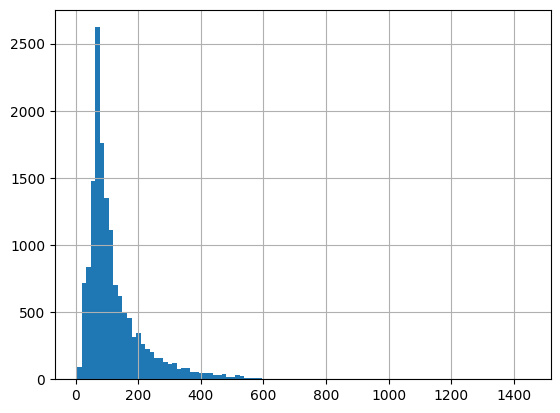

In [25]:
#<SOL>

average_number_tokens = []

for i in range(len(corpus)):
    average_number_tokens.append(len(corpus[i]))

average_number_tokens_pd = pd.Series(average_number_tokens)

average_number_tokens_pd.hist(bins = 100)

#</SOL>

Como vemos, por lo general, la mayoría de reviews suelen tener unos 100 tokens de media.

In [26]:
# Vemos como hemos crer

average_number_tokens

[101,
 161,
 109,
 311,
 250,
 129,
 107,
 55,
 405,
 80,
 87,
 191,
 212,
 69,
 23,
 55,
 56,
 61,
 213,
 84,
 38,
 32,
 105,
 92,
 219,
 84,
 234,
 47,
 96,
 129,
 104,
 411,
 146,
 63,
 24,
 90,
 62,
 109,
 52,
 122,
 170,
 339,
 170,
 88,
 46,
 64,
 72,
 425,
 118,
 74,
 195,
 80,
 73,
 436,
 82,
 52,
 102,
 336,
 87,
 154,
 76,
 36,
 302,
 32,
 47,
 167,
 56,
 143,
 25,
 104,
 88,
 63,
 52,
 46,
 112,
 147,
 170,
 130,
 382,
 89,
 110,
 275,
 108,
 65,
 20,
 78,
 135,
 72,
 116,
 82,
 101,
 198,
 180,
 71,
 189,
 288,
 79,
 21,
 359,
 130,
 99,
 61,
 70,
 73,
 77,
 210,
 141,
 137,
 197,
 147,
 142,
 43,
 35,
 61,
 195,
 84,
 33,
 74,
 180,
 81,
 93,
 240,
 100,
 83,
 64,
 30,
 99,
 92,
 150,
 65,
 131,
 111,
 59,
 71,
 72,
 239,
 150,
 72,
 212,
 57,
 112,
 97,
 267,
 50,
 62,
 206,
 79,
 44,
 103,
 450,
 374,
 36,
 109,
 60,
 63,
 97,
 179,
 124,
 72,
 171,
 145,
 98,
 335,
 90,
 105,
 130,
 84,
 72,
 91,
 92,
 60,
 59,
 121,
 102,
 210,
 155,
 162,
 264,
 118,
 64,
 476,
 73,
 

### *2.2. N-grams detection*

Gensim N-gram detection is purely based on the detection of tokens that appear next to each other with high frequency. Gensim `Phraser` can be parameterized to allow some intermediate tokens which are normally considered as links tokens in the English language. However, since we have already carried out lemmatization and stopword removal we can make use of a very simple use of method.

Two parameters are necessary:
   - `min_count`: Minimum length for N-grams
   - `threshold`: Minimum scoring for accepting N-grams. Higher values imply that fewer N-grams are accepted. The threshold is applied on a scoring function that depends on the frequency of the detected N-grams, as well as on the number of isolated occurrences of the component tokens.

Uniremos con un "_" todas las palabras adyacentes cuyo significado se complete al juntarse ambas.

In [27]:
phrase_model = Phrases(corpus, min_count=2, threshold=20)

print('\n============= First review in corpus =============')
print(corpus[0])
corpus = [el for el in phrase_model[corpus]] # We populate corpus again
print('\n============= First review after N-gram replacement =============')
print(corpus[0])

# Veamos como lo hemos realizado exitosamente


============= First review in corpus =============
['set', 'paris', 'year', '1910', 'retired', 'old', 'rich', 'opera', 'singer', 'decides', 'give', 'fortune', 'away', 'beautiful', 'cat', 'duchess', 'voiced', 'eva', 'gabor', 'kitten', 'jealous', 'butler', 'edgar', 'come', 'plan', 'kidnaps', 'cat', 'leaf', 'countryside', 'luckily', 'help', 'streetwise', 'independent', 'tomcat', 'named', 'thomas', 'malley', 'voiced', 'phil', 'harris', 'help', 'get', 'home', 'especially', 'meeting', 'good', 'friend', 'like', 'swinging', 'scat', 'cat', 'voiced', 'scatman', 'crothers', 'try', 'foil', 'edgar', 'plan', 'entertaining', 'edgy', 'post', 'walt', 'disney', 'death', 'animated', 'movie', 'couple', 'nice', 'jazzy', 'tune', 'like', 'memorable', 'everybody', 'want', 'cat', 'good', 'voice', 'acting', 'terrific', 'animation', 'time', 'even', 'time', 'computer', 'animation', 'one', 'greatest', 'disney', 'animated', 'movie', 'cult', 'disney', 'animated', 'fave', 'one', 'gem', 'day', 'work', 'well', 'highly

Let's save our clean reviews in a text file for later use.

In [28]:
corpus_df['clean_review'] = corpus

with open("imdb_lemmas_clean.txt", 'w', encoding='utf-8') as fout:
  for el in corpus_df['clean_review'].values.tolist():
    fout.write(' '.join(el) + '\n')

To be able to work with the corpus, we need to vectorize all its documents. To do so, there are two steps we need to carry out:

1. Calculate the dictionary
2. Transform the documents using the dictionary

### *2.3. Gensim dictionary*

As a first step for vectorizing documents, we need to create a dictionary containing all tokens in our text corpus and assign an integer identifier to each one of them.

The following code fragment generates such a dictionary and shows the first tokens in the dictionary. 

Crearemos un diccionario donde, cada token que aparece en nuestro corpus, será asignado con un valor numérico representativo del mismo.

In [29]:
# Create dictionary of tokens
D = Dictionary(corpus)
n_tokens = len(D)

print('The positive dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The positive dictionary contains 72575 terms
First terms in the dictionary:
0 : acting
1 : animated
2 : animation
3 : away
4 : beautiful
5 : butler_edgar
6 : cat
7 : come
8 : computer_animation
9 : countryside



Saved
207 words
The dictionary object contains several attributes and methods that can be useful for carrying out some cleaning tasks. You can check the available methods using 

```
dir(D)
```

Some of the most useful methods that we will use are:

   - ```add_documents```: updates the dictionary processing new documents

   - ```merge_with```: merges two dictionaries

   - ```save```, ```save_as_text```, ```load```, ```load_from_text```: can be used to give persistence to the dictionary and reading a previously calculated dictionary

   - ```id2token```: This is a Python dictionary for the mapping tokenid (a number) -> token (text representation). You can check that ```D[n]``` is equivalent to ```D.id2token[n]```

   - ```token2id```: A Python dictionary for the reverse mapping token -> tokenid

   - ```items```, ```keys```, ```values```, ```iteritems```, ```iterkeys```, ```itervalues```: Can be used to obtain al items (tokenid, token), all tokenids, or all token texts, or to iterate over them.

   - ```dfs```: A Python dictionary for the mapping tokenid -> Number of documents where the token appears

   - ```filter_tokens```, ```filter_extremes```, ```filter_n_most_frequent```: are used to remove elements from the dictionary, and ```compactify```is used to reassign tokenids to tokens for a more efficient representation.

   - ```doc2bow```: converts a document into its Bag of Words Representation

   - ```doc2idx```: transforms a document into a sequence of the tokenids of the words of the document

##### **Exercise 8**

1. Obtain a dataframe with 2 columns: `token` and `ndocs`, corresponding to the text of each token and the number of documents where the token appears

2. Sort the dataframe according to column `ndocs`. 

3. How many tokens appear in exactly one document? Remove them from the dataframe.

4. What are the most and less common tokens in the dictionary in terms of document occurrence?

3. Plot a histogram of the number of token appearances

Crearemos un datafram donde tendremos, para cada token que aparezca en los docs, el número de documentos en los que aparece; eliminamos los que solo aparecen una vez y ploteamos un histograma en función de sus ocurriencias.

<AxesSubplot:>

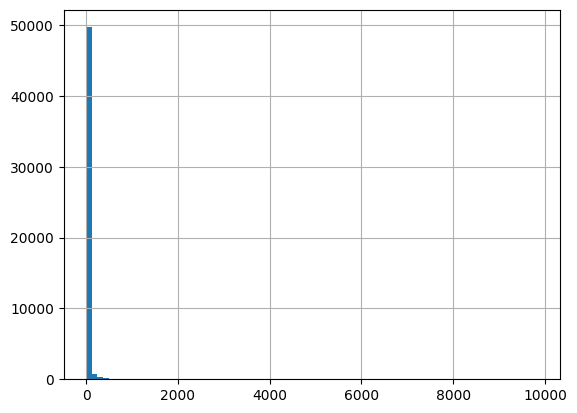

In [30]:
#<SOL>

kk = pd.DataFrame(columns=['token','ndocs'])

tokens_diccionario = []
freq_token = []

for i in range(len(D)):
    tokens_diccionario.append(D[i]) 
    freq_token.append(D.dfs[i])

kk['token'] = tokens_diccionario
kk['ndocs'] = freq_token

kk = kk.drop(kk[kk.ndocs == 1].index)

minimo_frq = kk['ndocs'].min()
min_token = kk.loc[kk['ndocs'] == minimo_frq]

maximo_frq = kk['ndocs'].max()
max_token = kk.loc[kk['ndocs'] == maximo_frq]

kk['ndocs'].hist(bins = 80)

#</SOL>

Por lo general, suelen aparecer pocas veces en documentos diferentes; o, al menos, es su tendencia

In [31]:
# Veamos como hemos creado el df bien y hemos eliminado los que aparecen solo una vez

kk

,token,ndocs
0,acting,3081
1,animated,144
2,animation,294
3,away,921
4,beautiful,931
...,...,...
71636,chungking_express,3
71724,improvisationally,2
71759,galasso,2
71981,distend,2


Next, we will filter out terms that appear in too few or too many of the documents in the dataset. This makes sense because:

   - terms that appear in most documents are probably not very informative in the general context of a particular corpus
   - terms that appear in a very reduced number of documents are not useful to find repetitive patterns across documents. In fact, in many cases, we find that many of the words that are eliminated for this reason can be typos.

Eliminamos del diccionario todo token que aparezca o muy pocas veces (menos de 4) o demasiadas (en más de un 80% de los documentos)

In [32]:
no_below = 4 #Minimum number of documents to keep a term in the dictionary
no_above = .80 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

The dictionary contains 29779 terms


You can check dictionary size has been considerably reduced with respect to the original vocabulary.

In [33]:
corpus_def = []
for sent in corpus:
  aux = [token for token in sent if token in D.token2id.keys()]
  corpus_def.append(aux)

corpus_df['clean_review'] = corpus_def

In [34]:
# Veamos que ya tenemos las reviews sin esos tokens eliminados previamente

corpus_df

,review,sentiment,clean_review
33003,"[set, paris, year, 1910, retired, old, rich, o...",positive,"[set, paris, retired, old, rich, opera_singer,..."
12172,"[basic, structure, story, beginning, middle, e...",negative,"[basic, structure, story, beginning_middle, en..."
5192,"[odd, willfully, skewed, biopic, dyan, thomas,...",negative,"[odd, willfully, skewed, biopic, dyan, thomas,..."
32511,"[okay, penelope, keith, miss, herringbone, twe...",negative,"[okay, miss, b, b, e, backbone, england, kille..."
43723,"[larger, life, figure, wyatt, earp, bat, maste...",positive,"[larger_life, figure, wyatt_earp, bat, masters..."
...,...,...,...
16645,"[6, 10, acting, great, good, acting, 4, 10, di...",negative,"[6, 10, acting, great, good, acting, 4_10, dir..."
14615,"[perhaps, biggest, waste, production, time, mo...",negative,"[perhaps, biggest, waste, production, time, mo..."
36865,"[hilarious, would, sworn, ed, wood, wrote, ter...",negative,"[hilarious, would, sworn, ed_wood, wrote, terr..."
20865,"[unsung, quiet, gem, tell, true, story, pow, e...",positive,"[unsung, quiet, gem, tell, true, story, pow, e..."


Sin embargo, los tokens no se pueden meter tal cual a un modelo de predicción sino que deben codificarse a nivel numérico. Para ello usaremos la codificación BoW y la TD-IDF

### *2.3. Bag-Of-Words (BoW)*

Next, let us create a numerical version of our corpus using the `doc2bow` method. In general, `D.doc2bow(token_list)` transforms any list of tokens into a list of tuples `(token_id, n)`, one per each token in `token_list`, where `token_id` is the token identifier (according to dictionary `D`) and `n` is the number of occurrences of such a token in `token_list`. 

Con esto conseguimos que cada token de cada review se represente como una tupla donde aparecerá (id del token en el diccionario, número de veces que aparece el token en dicho documento)

In [35]:
reviews_bow = [D.doc2bow(doc) for doc in corpus]

n_review = 1000
print('============= Review (lemmas) =============')
print(' '.join(corpus[n_review]))

print('\n============= Sparse vector representation =============')
print(reviews_bow[n_review])

print('\n============= Word counts for the review =============')
print(list(map(lambda x: (D[x[0]], x[1]), reviews_bow[n_review])))

============= Review (lemmas) =============
film really used location well amazing shot dark_disturbing film move_slowly constantly keep watching modern love worked well gold_coast film fantastic program year offering audience glimpse_australian cinema usually_neglected importantly_refreshing see australian_cinema taking cliché_aussie character story line seen done death year film would compliment_festival open_debate screening performance character well_developed cinematography fantastic interesting exploration family relationship environment

============= Sparse vector representation =============
[(13, 1), (73, 2), (89, 2), (107, 4), (153, 1), (157, 1), (170, 1), (204, 1), (206, 1), (220, 1), (224, 1), (280, 1), (446, 1), (486, 1), (518, 1), (528, 1), (662, 1), (673, 1), (770, 1), (1008, 1), (1057, 2), (1221, 1), (1225, 1), (1245, 1), (1378, 2), (1445, 1), (1553, 1), (2063, 1), (2128, 1), (2552, 1), (2590, 1), (3290, 1), (4182, 1), (4947, 1), (5673, 1), (5735, 1), (8082, 1), (11212

Note that we can interpret each element of corpus_bow as a `sparse_vector`. For example, a list of tuples 

    [(0, 1), (3, 3), (5,2)] 

for a dictionary of 10 elements can be represented as a vector, where any tuple `(id, n)` states that position `id` must take value `n`. The rest of the positions must be zero.

    [1, 0, 0, 3, 0, 2, 0, 0, 0, 0]

As a summary, we have obtained the following variables that will be relevant for the next sections:

   * `D`: A Gensim dictionary. Term strings can be accessed using numeric identifiers. For instance, `D[0]` contains the string corresponding to the first position in the BoW representation.
   * `mycorpus_bow`: BoW corpus. A list containing an entry per project in the dataset, and consisting of the (sparse) BoW representation for the abstract of that project.

mycorpus_bow = reviews_bow y tiene, para cada review un resumen de su index en el dict y el nº de veces que aparece en ese documento ern concreto. En eso se resume según BoW la representación numérica que relaciona o da sentido a unos tokens obtenidos tras el preprocesado de una cadena de texto.

Ya tenemos la sparse representation

### *2.4. TF-IDF vectorization*

Gensim TFIDF representation of a document is computed as

$$x_{ij} = \text{freq}_{ij} \log_2 \frac{\# docs}{\# docs_j}$$

where: 

   - $x_{ij}$ is the component of the TFIDF representation of document $i$ corresponding to term $j$
   - $\text{freq}_{ij}$ is the frequency of term $j$ in a document $i$ (i.e., number of occurrences divided by the number of tokens)
   - $\# docs$ is the total number of documents in the corpus
   - ${\# docs_j}$ is the number of documents in the corpus containing term $j$

In this way, terms that appear in fewer documents get emphasized over common terms appearing in many documents.

Gensim offers the possibility to change the *term frequency* and *inverse document frequency* calculation terms, but we will keep the defaults.

Note that, contrary to the Bag of Words (BoW) representation, the TFIDF representation does not depend just on the tokens of each document, but gets affected by the whole corpus through the IDF factor.

Gensim considers TFIDF as a model on its own and deals with it similarly to what is done with other models. Creating a TFIDF model is very simple

Con esto no solo tendremos en cuenta el número de aparición del token en el documento sino que también dependerá de todo el corpus (lo que da paso a más información respecto a cada uno de los documentos en comparación con la BoW representation)

In [36]:
tfidf = TfidfModel(reviews_bow)

A **TFIDF model cannot be updated** adding more documents. Otherwise, we would lose consistency, i.e., the TFIDF representation for a particular document would change before and after the TFIDF model gets updated.

From now on, `tfidf` can be used to convert any vector from the old representation (bow integer counts) to the new one (TFIDF real-valued weights), or to apply a transformation to a whole corpus

Veamos como cada token de cada documento se sustituye por una tupla (id del token en el diccionario, representación TFIDF de dicho token en dicho documento)

In [37]:
reviews_tfidf = tfidf[reviews_bow]
n_project = 1000
print('============= TFIDF representation for the project =============')
print(reviews_tfidf[n_review])

print('\n============= TFIDF applying the transformation only to the document =============')
print(tfidf[reviews_bow[n_review]])

============= TFIDF representation for the project =============
[(13, 0.10303186556063204), (73, 0.09299293171819176), (89, 0.0839552297866133), (107, 0.0788119729120782), (153, 0.04035973106414201), (157, 0.041908418884884106), (170, 0.03624598163546388), (204, 0.08344137508321578), (206, 0.0644902683898919), (220, 0.11629665955805626), (224, 0.06402022569086893), (280, 0.08830442967660285), (446, 0.18512567038139738), (486, 0.13188020665640368), (518, 0.04396272965195787), (528, 0.08866615013810306), (662, 0.09615821248254511), (673, 0.07362318078192463), (770, 0.09268434362670872), (1008, 0.08185496531201722), (1057, 0.16501900817670423), (1221, 0.09091586355696611), (1225, 0.11635671875384479), (1245, 0.11494211554395115), (1378, 0.26872714851940493), (1445, 0.12577848299554983), (1553, 0.12737282268051714), (2063, 0.09759670721778727), (2128, 0.07371556188177023), (2552, 0.152782283160089), (2590, 0.1898428984287813), (3290, 0.19124380849349917), (4182, 0.14291086694400915), (494

As for BOW, TFIDF provides a sparse document representation.

### *2.5. Memory efficient computation*

Optimización a nivel computacional

In the previous examples, the construction of the dictionary and the transformation of the corpus to BoW or TFIDF format required that said corpus of documents be available in a list in the execution environment, and therefore required it to be stored in RAM. For a small corpus, this is not a problem, but it can be an important limitation when dealing with a large corpus with millions or tens of millions of documents. These corpora are becoming more and more common in certain applications (consider Wikipedia entries, user opinions on large e-commerce platforms, processing of medical records, etc.).

One of the advantages of Gensim is that its implementation makes it easy to work with a corpus of these sizes. As explained in the Gensim documentation:

> Note that the corpus above resides fully in memory, as a plain Python list. In this simple example, it doesn’t matter much, but just to make things clear, let’s assume there are millions of documents in the corpus. Storing all of them in RAM won’t do. Instead, let’s assume the documents are stored in a file on disk, one document per line. Gensim only requires that a corpus must be able to return one document vector at a time.

>The full power of Gensim comes from the fact that a corpus doesn’t have to be a list, a NumPy array, a Pandas dataframe, or whatever. Gensim accepts any object that, when iterated over, successively yields documents.

The next fragment of code illustrates how the dictionary can be created from a corpus stored in a text file. You just need to create an iterator that returns a document at each iteration and keeps adding documents to the dictionary. Note that during the execution of the code, only one document is kept in memory at every iteration.

In [38]:
class IterableCorpus_fromfile:
    def __init__(self, filename):
        self.__filename = filename
    def __iter__(self):
        for line in open(self.__filename):
            # assume there's one document per line, tokens separated by whitespace
            yield line.lower()

MyIterCorpus = IterableCorpus_fromfile('imdb_lemmas_clean.txt')
newD = Dictionary()
for doc in MyIterCorpus:
  newD.add_documents([doc.split()])
no_below = 4 # Minimum number of documents to keep a term in the dictionary
no_above = .80 # Maximum proportion of documents in which a term can appear to be kept in the dictionary
newD.filter_extremes(no_below=no_below,no_above=no_above)

The code above can be further simplified if the iterator already carries out the tokenization of each document. In that case, the dictionary can be created with a simple command:

In [39]:
class IterableCorpus_fromfile:
    def __init__(self, filename):
        self.__filename = filename
    def __iter__(self):
        for line in open(self.__filename):
            # assume there's one document per line, tokens separated by whitespace
            yield line.lower().split()

MyIterCorpus = IterableCorpus_fromfile('imdb_lemmas_clean.txt')
newD = Dictionary(MyIterCorpus)
no_below = 4 # Minimum number of documents to keep a term in the dictionary
no_above = .80 # Maximum proportion of documents in which a term can appear to be kept in the dictionary
newD.filter_extremes(no_below=no_below,no_above=no_above)

print('Number of documents processed:', newD.num_docs)
print('Number of elements in dictionary:', len(newD))

Number of documents processed: 15000
Number of elements in dictionary: 29779


### *2.7. Compatibility with Numpy and Scipy*


Gensim contains efficient functions to convert Gensim Corpus (BoW, TFIDF) to Numpy dense matrices or Scipy Sparse Matrices. This can be useful, e.g., if we wish to use the vectorial representation of a Gensim corpus to train a classification or regression model using sklearn.

Similarly, we also have functions to convert Numpy or Scipy matrices into Gensim representation.

More information on the available utilities can be found in the [Gensim API matutils documentation](https://radimrehurek.com/gensim/matutils.html).


Sklearn also includes functions for tokenization and vectorization of documents. Specifically, it has the functions:
* [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) which implements both tokenization and word count (BoW) in a single class.
* [`TfidfTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer) which is responsible for obtaining the TF-IDF representation from a BoW representation.

* [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) which is equivalent to using `CountVectorizer()` followed by `TfidfTransformer()`.

A partir de este punto realizaremos el modelo capaz de predecir, a través de los tokens que conforman un documento, si el sentimiento al respecto de la review es bueno o malo.

## **3. Sentiment Analysis with BoW and TF-IDF representations**
---

Let's start by loading the problems labels.

A su vez los sentimientos positivos o negativos de cada review (las etiquetas), las pasamos a binario, respectivamente "1" y "0".

In [40]:
def get_binary_label(sentiment):
  return 1 if sentiment == "positive" else 0

corpus_df['binary_sentiment'] = corpus_df['sentiment'].apply(get_binary_label)

Y = corpus_df['binary_sentiment'].values
print(Y)

[1 0 0 ... 0 1 1]


In [41]:
# Veamos que tenemos tanto los tokens limpios asociados a su clasificación binaria

corpus_df

,review,sentiment,clean_review,binary_sentiment
33003,"[set, paris, year, 1910, retired, old, rich, o...",positive,"[set, paris, retired, old, rich, opera_singer,...",1
12172,"[basic, structure, story, beginning, middle, e...",negative,"[basic, structure, story, beginning_middle, en...",0
5192,"[odd, willfully, skewed, biopic, dyan, thomas,...",negative,"[odd, willfully, skewed, biopic, dyan, thomas,...",0
32511,"[okay, penelope, keith, miss, herringbone, twe...",negative,"[okay, miss, b, b, e, backbone, england, kille...",0
43723,"[larger, life, figure, wyatt, earp, bat, maste...",positive,"[larger_life, figure, wyatt_earp, bat, masters...",1
...,...,...,...,...
16645,"[6, 10, acting, great, good, acting, 4, 10, di...",negative,"[6, 10, acting, great, good, acting, 4_10, dir...",0
14615,"[perhaps, biggest, waste, production, time, mo...",negative,"[perhaps, biggest, waste, production, time, mo...",0
36865,"[hilarious, would, sworn, ed, wood, wrote, ter...",negative,"[hilarious, would, sworn, ed_wood, wrote, terr...",0
20865,"[unsung, quiet, gem, tell, true, story, pow, e...",positive,"[unsung, quiet, gem, tell, true, story, pow, e...",1


And save all the changes we have made in ``corpus_df`` for later use.

In [42]:
import pickle

def pickler(file: str, ob):
    """Pickle object to file"""
    with open(file, 'wb') as f:
        pickle.dump(ob, f)
    return 0

pickler("corpus_df_imbdb.pickle",corpus_df)

0

Since we have carried out the vectorization with Gensim,  we have to convert our vector representation into NumPy arrays so we can use Sklearn's classifiers. To do this, Gensim includes two functions: [corpus2dense](https://tedboy.github.io/nlps/generated/generated/gensim.matutils.corpus2dense.html), [corpus2csc](https://tedboy.github.io/nlps/generated/generated/gensim.matutils.corpus2csc.html). In general, when dealing with huge corpora, we will be interested in managing the sparse form of the data to save on computational costs.


In [43]:
# Obtenemos tanto de la representación BoW como TFIDF, su forma dense/sparse en array de numpy (donde cada posición es una lista con los valores de cada token en dicho documento) (es decir, tendremos 15k muestras con 20 y pico k atributos asociados al valor de cada token en el diccionario)
# para dicho documento en BoW (número de veces que aparece en el documento) o TFIDF (valor TF en dicho documento)

from gensim.matutils import corpus2dense, corpus2csc

n_tokens = len(D)
num_docs = len(reviews_bow)

# Convert BoW representacion
corpus_bow_dense = corpus2dense(reviews_bow, num_terms=n_tokens, num_docs=num_docs).T
corpus_bow_sparse = corpus2csc(reviews_bow, num_terms=n_tokens, num_docs=num_docs).T

# Convert TFIDF representacion
corpus_tfidf_dense = corpus2dense(reviews_tfidf, num_terms=n_tokens, num_docs=num_docs).T
corpus_tfidf_sparse = corpus2csc(reviews_tfidf, num_terms=n_tokens, num_docs=num_docs).T

##### **Exercise 9**

Train an SVM classifier with the BoW representation of the IMDB dataset. Use the Sklearn function ``train_test_split`` to split the BOW representation of the reviews with a $70/30$ ratio each and a random state of $42$. Find the best hyperparameters for the SVM (``C`` and ``kernel``) via cross-validation with [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). Evaluate the performance of the classifier based on the [R2 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html).

Creamos el SVM clasiffier para la representación BoW de los datos

In [44]:
# Obtenemos conjunto de entrenamiento y test en una relación 70/30

X_train, X_test, y_train, y_test = train_test_split(corpus_bow_sparse, Y, test_size=0.3, random_state=42)

In [45]:
# Analizamos el SVM con el dataset BoW dejando los parámetros por defecto

clf_SVM = SVC()
BoW_SVM = clf_SVM.fit(X_train,y_train)
y_pred = BoW_SVM.predict(X_test)
print('El accuracy usando SVM en el dataset BoW sin analizar los mejores parámetros es de: ' + str(accuracy_score(y_test, y_pred)))
print('')
print('La respectiva matriz de confusión: ')
print(confusion_matrix(y_test,y_pred))

El accuracy usando SVM en el dataset BoW sin analizar los mejores parámetros es de: 0.8675555555555555

La respectiva matriz de confusión: 
[[1915  349]
 [ 247 1989]]


In [47]:
# Realizamos el estudio paramétrico de los hiperparámetros del SVM

param_grid = {
    "C": [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0],
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid']
    }

grid_cv = GridSearchCV(SVC(), param_grid, cv = 2, n_jobs = -1)
grid_cv.fit(X_train,y_train)
print('El mejor estimador a usar: ' + str(grid_cv.best_estimator_))
print('El mejor parámetro a usar: ' + str(grid_cv.best_params_))

El mejor estimador a usar: SVC(C=10.0)
El mejor parámetro a usar: {'C': 10.0, 'kernel': 'rbf'}


In [48]:
# Creamos el modelo con los mejores hiperparámetros

clf_SVM_BoW = SVC(C=10.0, kernel = 'rbf')
clf_SVM_BoW.fit(X_train,y_train)
y_pred = clf_SVM_BoW.predict(X_test)
print('El accuracy usando SVM en el dataset BoW con los mejores parámetros es de: ' + str(accuracy_score(y_test, y_pred)))
print('')
print('La respectiva matriz de confusión: ')
print(confusion_matrix(y_test,y_pred))

El accuracy usando SVM en el dataset BoW con los mejores parámetros es de: 0.8837777777777778

La respectiva matriz de confusión: 
[[1973  291]
 [ 232 2004]]


Vemos una cierta mejora en el accuracy al utilizar hiperparámetros algo más óptimos. Veamos los resultados usando la representación TF-IDF de los token en los documentos.

##### **Exercise 10**

Mimic the steps from Exercise 9 to train an SVM classifier with the TF-IDF representation.

Creamos el SVM clasiffier para la representación TF-IDF de los datos

In [50]:
# Obtenemos conjunto de entrenamiento y test en una relación 70/30

X_train, X_test, y_train, y_test = train_test_split(corpus_tfidf_sparse, Y, test_size=0.3, random_state=42)

In [51]:
# Analizamos el SVM con el dataset TD-IDF dejando los parámetros por defecto

clf_SVM = SVC()
TFIDf_SVM = clf_SVM.fit(X_train,y_train)
y_pred = TFIDf_SVM.predict(X_test)
print('El accuracy usando SVM en el dataset TFIDF sin analizar los mejores parámetros es de: ' + str(accuracy_score(y_test, y_pred)))
print('')
print('La respectiva matriz de confusión: ')
print(confusion_matrix(y_test,y_pred))

El accuracy usando SVM en el dataset TFIDF sin analizar los mejores parámetros es de: 0.9017777777777778

La respectiva matriz de confusión: 
[[2018  246]
 [ 196 2040]]


Ya de base supera l mejor modelo usando la representación BoW de los datos. Es lógico ya que tal y como vimos en teoría, la representación TF-IDF proporciona más información de la frase al referirse también al resto del corpus.

In [52]:
# Realizamos el estudio paramétrico de los hiperparámetros del SVM

param_grid = {
    "C": [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0],
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid']
    }

grid_cv = GridSearchCV(SVC(), param_grid, cv = 2, n_jobs = -1)
grid_cv.fit(X_train,y_train)
print('El mejor estimador a usar: ' + str(grid_cv.best_estimator_))
print('El mejor parámetro a usar: ' + str(grid_cv.best_params_))

El mejor estimador a usar: SVC(C=3.0)
El mejor parámetro a usar: {'C': 3.0, 'kernel': 'rbf'}


In [53]:
# Creamos el modelo con los mejores hiperparámetros

clf_SVM_TFIDF = SVC(C=3.0, kernel = 'rbf')
clf_SVM_TFIDF.fit(X_train,y_train)
y_pred = clf_SVM_TFIDF.predict(X_test)
print('El accuracy usando SVM en el dataset TFIDF usando los mejores parámetros es de: ' + str(accuracy_score(y_test, y_pred)))
print('')
print('La respectiva matriz de confusión: ')
print(confusion_matrix(y_test,y_pred))

El accuracy usando SVM en el dataset TFIDF usando los mejores parámetros es de: 0.9051111111111111

La respectiva matriz de confusión: 
[[2036  228]
 [ 199 2037]]


Si bien hemos aprendido cada uno de los pasos necesarios para un buen preprocesado de datos en forma de strings, vemos como las representaciónes BoW y TFIDF de los tokens para un problema de análisis dfe sentimientos pueden dar resultados bastante buenos aproximando a un accuracy de un 88.3% y 90.5% respectivamente.

Los resultados son normales dada la naturaleza del problema. En el análisis de sentimientos no necesitamos una profundización exhaustiva en la correlación y orden de las palabras sino que existen muchas palabras que se relacionan directamente con un sentimiento bueno o malo por parte del escritor de la "review". Si bien BoW o TFIDF no dan excesiva información del segmento de texto, si plasman bien la frecuencia de aparición de las palabras en el mismo, donde, según la cantidad de veces que aparecen ciertas palabras (directamente ligadas a un sentimiento) en un texto, puede predecir con bastante exactitud el sentimiento/etiqueta asociada al mismo.

Finalmente, cabe destacar que no contamos con un desbalanceo en las clases positivo/negativo y es por ello que el modelo, aparte de predecir bien en general, tiene muy buena capacidad de predicción para ambas clases (podemos ver esto en las diagonales de las matrices de confusión las cuales se relacionan directamente con las etiquetas clasificadas correctamente para cada clase).

---
In this first laboratory, we have covered the necessary preprocessing steps that need to be applied to a text corpus previous to its vectorization using several state-of-the-art Python libraries. We have then seen how to obtain BoW and TFIDF representations based on the Gensim library and how to use them for a Sentiment Analysis problem. 

While we will see that Bag-of-Words and TF-IDF as they neither capture the context of words nor allow for similarity comparison, it is still important to know how they work and how to use them, since they still provide quite good results in some tasks, as we have seen in this notebook. 

To finish, it is also important that you get confident with the Genism library as you will be using it a lot in this course!
